In [1]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

import time
start_time = time.time()

In [2]:
from google.cloud import storage

In [3]:
%%time
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/jasmeetsingh/df_final_for_analysis/')
df.count()

22/12/08 01:39:20 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 40.8 ms, sys: 5.56 ms, total: 46.4 ms
Wall time: 28.8 s


3119357

In [4]:
df.limit(5).toPandas()

,created_at,id,geo_coordinates,user_name,followers_count,verified_user,user_location,user_description,reply_count,retweet_count,retweeted_status,tweet_text,text
0,Mon Aug 08 20:25:07 +0000 2022,1556738297606569994,None,Nebula 🛹☮️,9247,False,ShitholeImmigrant,Proud Liberal #Betocrat #BetoForGovernor #Vote...,20,105,"(None, Mon Aug 08 15:17:00 +0000 2022, None, (...",School choice critics worry that the policy co...,rt @texastribune: school choice critics worry ...
1,Mon Aug 08 20:25:07 +0000 2022,1556738297526902787,None,Sydney Rey Franklin,457,False,"Cincinnati, OH",@enquirer real estate enterprise reporter // F...,0,1,"(None, Fri Aug 05 12:34:28 +0000 2022, None, (...",Design LAB: Grade school students learn to be ...,rt @cweiser: design lab: grade school students...
2,Mon Aug 08 20:25:20 +0000 2022,1556738350953861121,None,Kate F,661,False,California,An aware & concerned American.,0,6,"(None, Tue Aug 02 13:16:19 +0000 2022, None, (...",If the United States aims to outcompete other ...,rt @csetgeorgetown: if the united states aims ...
3,Mon Aug 08 20:25:22 +0000 2022,1556738360412086280,None,David Engelson,692,False,"Staten Island, NY","Cogito, ergo sum. Wife : @CeliaEngelson. Daugh...",113,352,"(None, Mon Aug 08 19:52:38 +0000 2022, [0, 140...",I’ve had a few teachers ask me for personalize...,rt @hiitaylorblake: i’ve had a few teachers as...
4,Mon Aug 08 20:25:25 +0000 2022,1556738374286934018,None,Kathryn Moore,186,False,None,None,24,364,"(None, Mon Aug 08 18:02:16 +0000 2022, None, (...",BREAKING: A coalition of charter schools filed...,rt @deangeliscorey: breaking: a coalition of c...


In [5]:
count1 = df.count()
count2 = df.filter('retweeted_status is null').count()
clear_output(wait = False)

In [6]:
print('Count of all tweets:', count1)
print('Count of all original tweets:', count2)

Count of all tweets: 3119357
Count of all original tweets: 318991


## Identify the most prolific / influential Twitterers
### By message volume (original content)

In [7]:
# By message volume (original content)

In [8]:
df_original_content = df.filter("retweeted_status is null and verified_user == True")
print(type(df_original_content))
res = df_original_content.groupby("user_name").agg(count('*').alias('count_of_tweets'))\
                         .select(['user_name','count_of_tweets'])\
                         .orderBy('count_of_tweets', ascending = False).limit(20).toPandas()

<class 'pyspark.sql.dataframe.DataFrame'>


In [9]:
res

,user_name,count_of_tweets
0,TOI Cities,102
1,Corey A. DeAngelis,77
2,The Washington Times,71
3,Fox News,65
4,Chalkbeat,51
5,U.S. News Education,48
6,John M. Guilfoil,40
7,Shawn Cabbagestalk,39
8,Hindustan Times,38
9,MLive,36


### By message retweet (how often their messages are being retweeted). 

In [10]:
top_users = list(res['user_name'].values)
filter_string = "user_name == '" + top_users[0] + "'"
for i in top_users[1:]:
    filter_string += (" or user_name == '" + i + "'")
    
top_user_tweets = df_original_content.filter(filter_string)
top_user_tweets.count()

883

In [11]:
top_user_tweets_df = top_user_tweets.toPandas()

In [12]:
user_text_df = top_user_tweets_df[['user_name','text', 'tweet_text']]
user_text_df.head()

,user_name,text,tweet_text
0,Chalkbeat,covid relief money helps colorado schools pay ...,COVID relief money helps Colorado schools pay ...
1,Corey A. DeAngelis,@joshshapiropa you went to private school and ...,@JoshShapiroPA you went to private school and ...
2,Corey A. DeAngelis,@genefortexas texas public school funding per ...,@GeneforTexas Texas public school funding per ...
3,TOI Cities,parents give good marks to schools of excellen...,Parents give good marks to schools of excellen...
4,Nation Africa,"bail us out, magoha tells private schools over...","Bail us out, Magoha tells private schools over..."


In [13]:
df1 = df.filter('retweeted_status is not null')

In [14]:
retweet_table = df1.withColumn("tweet_text", F.lower(F.col("tweet_text")))\
                            .select(['text', 'tweet_text', 'retweet_count', 'user_name','retweeted_status'])\
                            .groupby(['user_name'])\
                            .agg((avg('retweet_count')).alias('average_retweets_per_tweet')).toPandas()

In [15]:
users_table = res #top_user_tweets_df[['text', 'tweet_text', 'user_name', 'id']]

In [16]:
display(users_table.sort_values(by = 'count_of_tweets', ascending = False).head())
display(len(users_table))
display(retweet_table.sort_values(by = 'average_retweets_per_tweet', ascending = False).head())
display(len(users_table))

,user_name,count_of_tweets
0,TOI Cities,102
1,Corey A. DeAngelis,77
2,The Washington Times,71
3,Fox News,65
4,Chalkbeat,51


20

,user_name,average_retweets_per_tweet
911622,xeexoosee,232107.0
619420,EURILDES,229490.0
592558,҉,157951.0
1159031,Jeanine Thurston,116043.0
1032317,Travelling Soldier,115130.0


20

In [18]:
retweets_user_table = pd.merge(left = users_table, right = retweet_table, left_on = 'user_name', right_on = 'user_name', how = 'left')

In [19]:
retweets_user_table[['user_name', 'count_of_tweets','average_retweets_per_tweet']].sort_values(by = 'average_retweets_per_tweet', ascending = False).head(10)

,user_name,count_of_tweets,average_retweets_per_tweet
1,Corey A. DeAngelis,77,48.775031
14,Houston Chronicle,32,32.000000
4,Chalkbeat,51,3.730769
18,CBSColorado,29,2.000000
16,The 74,30,1.923077
2,The Washington Times,71,1.363636
15,Eyewitness News,30,1.285714
12,Pittsburgh Post-Gazette,33,1.200000
8,Hindustan Times,38,1.019608
0,TOI Cities,102,1.000000


### Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?


In [20]:
entity_extraction = df.select(['user_name', 'user_description', 'followers_count', 'id'])

In [21]:
df.select(['user_name', 'user_description']).limit(40).toPandas()

,user_name,user_description
0,Nebula 🛹☮️,Proud Liberal #Betocrat #BetoForGovernor #Vote...
1,Sydney Rey Franklin,@enquirer real estate enterprise reporter // F...
2,Kate F,An aware & concerned American.
3,David Engelson,"Cogito, ergo sum. Wife : @CeliaEngelson. Daugh..."
4,Kathryn Moore,None
5,Traci B,None
6,Pat Kane,Not your typical central CA retiree. But I do ...
7,Silence DoGood,"Sometimes MAD, rest of time Embarrassed. Avera..."
8,Manny James,Varsity Passing Game Coordinator & Running Bac...
9,Matthew L. West V,None


In [22]:
# entity_dict = {}
# entity_dict['government'] = ['gov', 'department of', 'president', 'congress', 'senate', 'prime minister', 'vp', 
#                              'white house', 'mayor', 'parliament', 'democrat', 'republican', 'democracy']
# entity_dict['university and schools'] = ['university', 'school','academia', 'professor', 'teacher', 'instructor', 'academy', 'researcher']
# entity_dict['nonprofit organizations'] = ['non profit', 'donation', 'donate', 'ngo', 'service', 'donors']
# entity_dict['news outlets'] = ['news', 'daily', 'journal', 'writer', 'editor', 'journalist', 'times', 'abc', 'nbc', 'fox', 'msnbc']

In [23]:
%%time

@F.udf
def get_entity(user_description, followers_count, user_name):
    if (followers_count < 500):
        return "Others"
    
    if(user_description == None or user_name == None):
        return "Influencer"
    user_name = user_name.lower()
    user_description = user_description.lower()
    
    if('school' in user_name or 'school' in user_description or 'university' in user_name or 'university' in user_description
      or 'professor' in user_name or 'professor' in user_description or 'research' in user_name or 'research' in user_description):
        return "School and Universities"
    
    elif('non profit' in user_name or 'non profit' in user_description  or 'ngo' in user_name or 'ngo' in user_description 
       or 'donate' in user_description or 'donate' in user_name):
        return "Nonprofit Organizations"
    
    elif('gov' in user_description or 'gov' in user_name or 'Department of' in user_name or 'Department of' in user_description
      or 'president' in user_description or 'president' in user_name or 'senate' in user_description or 'senate' in user_name
      or 'gop' in user_description or 'gop' in user_name or 'mayor' in user_description or 'mayor' in user_name
      or 'democ' in user_description or 'democ' in user_name or 'republ' in user_description or 'republ' in user_name
      or 'white house' in user_description or 'white house' in user_name or 'speaker' in user_description or 'speaker' in user_name
      or 'parliament' in user_description or 'parliament' in user_name or 'congress' in user_description or 'congress' in user_name
      or 'minister' in user_description or 'minister' in user_name or 'law' in user_description or 'law' in user_name):
        return "Government"
    
    elif('news' in user_description or 'news' in user_name or 'journalist' in user_description or 'journalist' in user_name
      or 'daily' in user_description or 'daily' in user_name or 'journal' in user_description or 'journal' in user_name
      or 'times' in user_description or 'times' in user_name or 'post' in user_description or 'post' in user_name
      or 'bbc' in user_description or 'bbc' in user_name or 'fox' in user_description or 'fox' in user_name
      or 'abc' in user_description or 'abc' in user_name or 'nbc' in user_description or 'nbc' in user_name
      or 'msnbc' in user_description or 'msnbc' in user_name or 'cnbc' in user_description or 'cnbc' in user_name
      or 'ndtv' in user_description or 'ndtv' in user_name or 'editor' in user_description or 'editor' in user_name
      or 'host' in user_description or 'host' in user_name or 'writer' in user_description or 'writer' in user_name
      or 'report' in user_description or 'report' in user_name or 'truth' in user_description or 'truth' in user_name
      or 'media' in user_description or 'media' in user_name or 'paper' in user_description or 'paper' in user_name):
        return "News"
    
    else:
        return "Influencer"
     
entity_extraction = df.withColumn("entity", get_entity("user_description", "followers_count", "user_name"))

CPU times: user 10.1 ms, sys: 0 ns, total: 10.1 ms
Wall time: 126 ms


In [24]:
%%time
entity_analysis = entity_extraction.select(['user_name', 'user_description', 'entity', 'id']).groupby('entity').agg(count('id')).toPandas()
pd.set_option('display.max_colwidth', 1000)
entity_extraction.select(['user_name', 'user_description', 'entity']).limit(30).toPandas()

CPU times: user 41.6 ms, sys: 17.2 ms, total: 58.8 ms
Wall time: 10 s


,user_name,user_description,entity
0,Nebula 🛹☮️,Proud Liberal #Betocrat #BetoForGovernor #VoteGOPOut #TurnTexasBlue2022 #WeAreTheCavalry #BLM #HumanRights #GunControlNOW #JusticeMatters #TrumpCrimeFamily,Government
1,Sydney Rey Franklin,"@enquirer real estate enterprise reporter // Formerly @nytrealestate, @archpaper // @Syr_Arch & @GoldringAJs Alum ‘15 // send tips to: sfranklin@enquirer.com",Others
2,Kate F,An aware & concerned American.,Influencer
3,David Engelson,"Cogito, ergo sum. Wife : @CeliaEngelson. Daughter : Sadie. Politics, Technology & Science. Miami Hurricanes. Miami Heat. Miami Dolphins.",Influencer
4,Kathryn Moore,None,Others
5,Traci B,None,Others
6,Pat Kane,Not your typical central CA retiree. But I do text in complete sentences.,Others
7,Silence DoGood,"Sometimes MAD, rest of time Embarrassed. Average middle Road American.",Others
8,Manny James,Varsity Passing Game Coordinator & Running Backs Coach @ Valley Vista High School #MonsoonSzn ⛈⛈ I 7on7 #TopDawgElite 🔝🐶I,Others
9,Matthew L. West V,None,Influencer


In [25]:
entity_extraction.groupby('entity').agg(first('user_name'), first('user_description')).toPandas()

,entity,first(user_name),first(user_description)
0,Nonprofit Organizations,Anamaria_Knight,All about global learning and learning communities @participatelrng. Strong believer that connection is at the heart of learning. #UnitingOurWorld
1,Government,Avi Small,new yorker | first deputy press secretary for @GovKathyHochul
2,Influencer,K,None
3,School and Universities,Tripp Aldredge,Public School Executive. Educator. Musician. Thinker. Principal @FDPatriot.
4,Others,Sydney Rey Franklin,"@enquirer real estate enterprise reporter // Formerly @nytrealestate, @archpaper // @Syr_Arch & @GoldringAJs Alum ‘15 // send tips to: sfranklin@enquirer.com"
5,News,ABS-CBN News,"Stories, video, and multimedia for Filipinos worldwide, from ABS-CBN News and Current Affairs"


,entity,count(id)
4,Others,1646245
2,Influencer,1047650
5,News,166735
1,Government,154629
3,School and Universities,96456
0,Nonprofit Organizations,7642


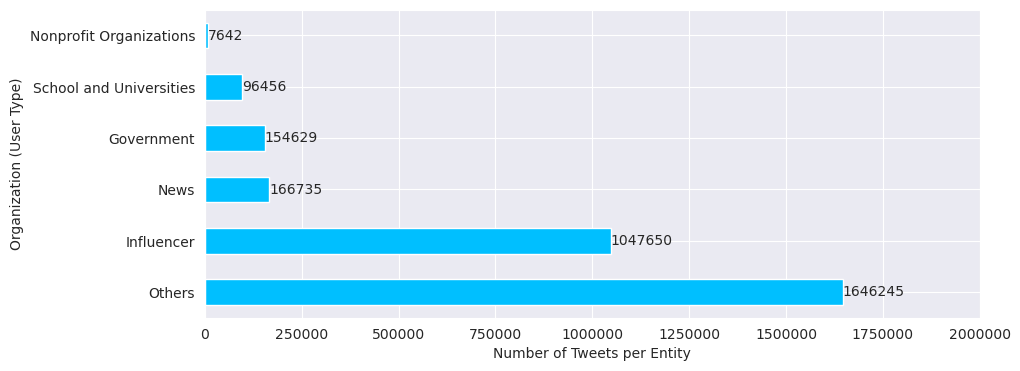

In [26]:
import seaborn as sns
sns.set_style("dark")
plt.rcParams["figure.figsize"] = (10, 4)
entity_analysis.sort_values(by = 'count(id)', inplace = True, ascending = False)
display(entity_analysis)
fig = entity_analysis.plot(kind='barh', legend=None, color= 'deepskyblue', grid = True)
fig.set_xlabel('Number of Tweets per Entity')
fig.set_ylabel('Organization (User Type)')
fig.set_yticklabels(entity_analysis.entity)
fig.bar_label(fig.containers[0], fmt = '%d', label_type='edge')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 0)
plt.xlim([-5, 2000000])
plt.show()

In [27]:
%%time 
try:
    entity_extraction.write.\
                            parquet("gs://msca-bdp-students-bucket/shared_data/jasmeetsingh/df_final_for_analysis_with_entity")
except:
    pass

clear_output(wait = False)

CPU times: user 5.36 ms, sys: 165 µs, total: 5.53 ms
Wall time: 229 ms


In [28]:
entity_analysis.head()

,entity,count(id)
4,Others,1646245
2,Influencer,1047650
5,News,166735
1,Government,154629
3,School and Universities,96456


In [29]:
entity_analysis_retweet = entity_extraction.groupby('entity').agg(avg('retweet_count')).toPandas()
entity_analysis_retweet

,entity,avg(retweet_count)
0,Nonprofit Organizations,1543.181462
1,Government,1465.078818
2,Influencer,1773.508101
3,School and Universities,640.020366
4,Others,2762.052174
5,News,1463.064124


,entity,avg(retweet_count)
0,Nonprofit Organizations,1543.181462
1,Government,1465.078818
2,Influencer,1773.508101
3,School and Universities,640.020366
4,Others,2762.052174
5,News,1463.064124


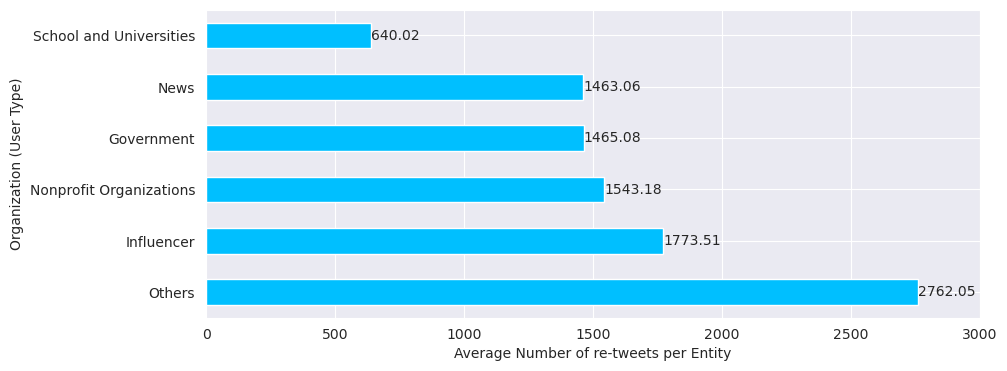

In [30]:
plt.rcParams["figure.figsize"] = (10, 4)
display(entity_analysis_retweet)
entity_analysis_retweet.sort_values(by = 'avg(retweet_count)', inplace = True, ascending = False)
fig = entity_analysis_retweet.plot(kind='barh', legend=None, color= 'deepskyblue', grid = True)
fig.set_xlabel('Average Number of re-tweets per Entity')
fig.set_ylabel('Organization (User Type)')
fig.set_yticklabels(entity_analysis_retweet.entity)
fig.bar_label(fig.containers[0], label_type='edge')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation = 0)
plt.xlim([-5, 3000])
plt.show()

In [31]:
print("--- Total Time to run the notebook: %s seconds ---" % (time.time() - start_time))

--- Total Time to run the notebook: 335.2864329814911 seconds ---
